# Define Model

In [ ]:
# PDE_model.py

import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from PIL import Image

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Change to that directory
os.chdir(notebook_dir)

class ForestFirePDE: # PDE model to simulate fire spread in forest

    def __init__(self, k, epsilon, alpha, u_pc, q, spatial_length,spatial_resolution, temporal_length, delta_t,initial_fire = [],beta_t0 = [],topography = []):
        '''
        Initialize the simulation with parameters.
        
        k: diffusion coefficient 
        epsilon:  inverse of activation energy of fuel
        alpha: natural convection
        u_pc: phase change threshold
        q: reaction heat
        spatial_length: map length
        spatial_resolution: simulation mash length
        temporal_length: number of dt, total simulation time = temporal_length * delta_t
        delta_t: dt
        beta_t: fuel distribution
        topography: if any (normalized to scale 1), topography[0] is gradient on x, and topography[1] is gradient on y
        wind_x / wind_y: the effect of wind
        '''
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.u_pc = u_pc
        self.q = q
        self.spatial_length = spatial_length
        self.spatial_resolution = spatial_resolution
        self.dx = spatial_length / spatial_resolution
        self.dy = self.dx
        self.temporal_length = temporal_length
        self.delta_t = delta_t
        self.initial_fire = initial_fire
        self.beta_t0 = beta_t0
        self.topography = topography
        
        # Initialize maps for temperature (u_t) and fuel (beta_t)
        self.u_t = np.zeros((temporal_length, spatial_resolution, spatial_resolution), dtype=np.float32)
        
        self.beta_t = np.zeros((temporal_length, spatial_resolution, spatial_resolution), dtype=np.float32)
        
    def init_conditions(self):
        # Initial conditions for temperature (Gaussian centered near the middle), and for fuel (uniformly random)
        x, y = np.meshgrid(np.linspace(0, self.spatial_length , self.spatial_resolution),
                           np.linspace(0, self.spatial_length , self.spatial_resolution))   
        
        self.wind_x = 0.1*np.sin(0.0 * x + 170/180 * np.pi)
        self.wind_y = 0.1*np.cos(0.0 * y + 170/180 * np.pi)
        
        # if any topography
        if len(self.topography) > 0:
            self.wind_x += self.topography[0]
            self.wind_y += self.topography[1]
        
        # if we set up any initial fire positions, else just use [[60,20],[20,60]]
        if len(self.initial_fire) > 0:
            for i in range(len(self.initial_fire)):
                
                initial_fire_x = self.initial_fire[i][0]
                initial_fire_y = self.initial_fire[i][1]
                
                self.u_t[0] += 6 * np.exp(-0.05 * ((x - initial_fire_x)**2 + (y - initial_fire_y)**2))
        else:
            self.u_t[0] = 6 * np.exp(-0.05 * ((x - 60)**2 + (y - 20)**2)) + 6 * np.exp(-0.05 * ((x - 20)**2 + (y - 60)**2))
        
        # if there is fuel input, and if not, randomnize it between 0 to 1
        if len(self.beta_t0) > 0:
            self.beta_t[0] = self.beta_t0
        else:
            self.beta_t[0] = np.random.uniform(0, 1, (self.spatial_resolution, self.spatial_resolution))     
        
    def boundary_conditions(self, t):
        # Apply zero boundary conditions to temperature and fuel
        self.u_t[t, 0, :] = self.u_t[t, -1, :] = 0
        self.u_t[t, :, 0] = self.u_t[t, :, -1] = 0
        self.beta_t[t, 0, :] = self.beta_t[t, -1, :] = 0
        self.beta_t[t, :, 0] = self.beta_t[t, :, -1] = 0
    
    def laplacian_operator(self, map_x):
        # Compute the Laplacian with second-order finite differences
        laplace_map = np.zeros_like(map_x)
        laplace_map[1:-1, 1:-1] = (
            map_x[2:, 1:-1] + map_x[:-2, 1:-1] + map_x[1:-1, 2:] + map_x[1:-1, :-2] - 4 * map_x[1:-1, 1:-1]
        ) / (self.dx ** 2)
        return laplace_map
    
    def gradient_operator(self, map_x):
        # Compute the gradient using finite differences
        grad_x = np.zeros_like(map_x)
        grad_y = np.zeros_like(map_x)
        
        grad_x[:, 1:-1] = (map_x[:, 2:] - map_x[:, :-2]) / (2.0 * self.dx)        
        grad_y[1:-1, :] = (map_x[2:, :] - map_x[:-2, :]) / (2.0 * self.dx)

        
        return grad_x, grad_y
    
    def heaviside_step_function(self, x):
        return np.where(x >= self.u_pc, 1, 0)
    
    def update(self):
        for t in range(1, self.temporal_length):
            # Calculate Laplacian for diffusion and gradients for convection
            u = self.u_t[t-1]
            beta = self.beta_t[t-1]
            lap_u = self.laplacian_operator(u)
            grad_u_x, grad_u_y = self.gradient_operator(u)

            # Compute convection term
            convection = -(self.wind_x * grad_u_x + self.wind_y * grad_u_y)

            # Update temperature
            f_u_beta = self.heaviside_step_function(u) * beta * np.exp(u / (1 + self.epsilon * u)) - self.alpha * u
            self.u_t[t] = u + self.delta_t * (self.k * lap_u + convection + f_u_beta)

            # Update fuel
            g_u_beta = -self.heaviside_step_function(u) *  self.epsilon /  self.q * beta * np.exp(u / (1 + self.epsilon * u))
            self.beta_t[t] = beta + self.delta_t * g_u_beta

            # Apply boundary conditions
            self.boundary_conditions(t)

    def plot_t_and_f(self,cur_time):

        plt.figure(figsize=(6, 5))


        plt.imshow(self.u_t[int(cur_time / self.delta_t)], cmap='jet', interpolation='nearest', vmin=-2, vmax=6, origin='lower')
        plt.colorbar(label=r'Temperature')
        
        arrow_scale = int(7 * self.spatial_resolution / 128)
        
        X, Y = np.meshgrid(np.arange(0, self.spatial_resolution, arrow_scale), np.arange(0, self.spatial_resolution, arrow_scale))            
        
        U = self.wind_x[::arrow_scale, ::arrow_scale]  # Downsample wind_x for visualization
        V = self.wind_y[::arrow_scale, ::arrow_scale]  # Downsample wind_y for visualization

        plt.quiver(X, Y, U, V, color='black')
        
        plt.title(r"Temperature (u) at Time = " + str(cur_time))
        plt.xlabel(r"x")
        plt.ylabel(r"y")

        plt.xticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_resolution / 2),self.spatial_resolution])
        plt.yticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_resolution / 2),self.spatial_resolution])
        
        plt.savefig('temperature_time' + str(cur_time), dpi=300, bbox_inches='tight')
            
        plt.show()


        plt.figure(figsize=(6, 5))
        plt.imshow(self.beta_t[int(cur_time/self.delta_t)], cmap='copper', interpolation='nearest', origin='lower')
        plt.colorbar(label='Fuel')

        plt.title("Fuel (u) at Time = " + str(cur_time))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_resolution / 2),self.spatial_resolution])
        plt.yticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_resolution / 2),self.spatial_resolution])
        
        plt.savefig('fuel_time' + str(cur_time), dpi=300, bbox_inches='tight')
            
        plt.show()

    
    def run(self):
        self.init_conditions()
        self.update()
        return self.beta_t

# Parameters

In [72]:
# Parameters
k = 0.1
epsilon = 0.3
alpha = 0.001
u_pc = 3
q = 1
#dx = 90 / 128
spatial_resolution = 438
spatial_length = 300
temporal_length = 10000
delta_t = 25/500 * 4


# Set up initial fire position

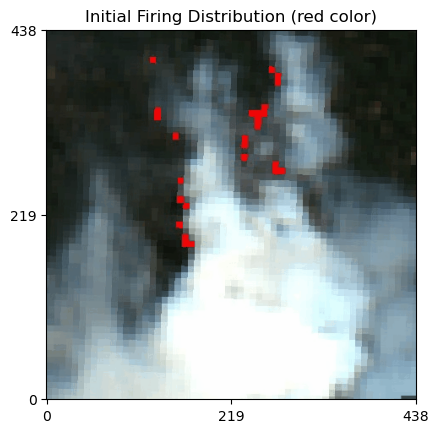

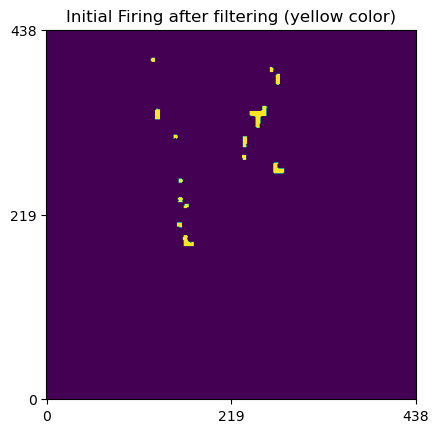

Inital firing indices are: [[124 400]
 [124 401]
 [124 402]
 ...
 [281 270]
 [281 271]
 [281 272]]


In [60]:
def get_frame_pixels(gif_path, frame_index,title):
    thepixels = {}
    with Image.open(gif_path) as im:

        im.seek(frame_index)
        frame = im.copy()

        # Convert frame to NumPy array
        frame_array = np.array(frame)[20:458,20:458]
        

        # Store pixel data in the dictionary
        thepixels[frame_index] = frame_array

        # Optionally, display the frame
        plt.imshow(np.flipud(frame_array))
        plt.title(title)
        plt.xticks([0,spatial_resolution / 2,spatial_resolution],[0,int(spatial_resolution / 2),spatial_resolution])
        plt.yticks([0,spatial_resolution / 2,spatial_resolution],[spatial_resolution,int(spatial_resolution / 2),0])
        plt.savefig(f'Frame {frame_index} (Tree distribution) at Time = 0', dpi=300, bbox_inches='tight')
        plt.show()



    return frame_array

initial_fire_img = get_frame_pixels('Initial Firing.tiff',0,'Initial Firing Distribution (red color)')

lower_red = np.array([230, 0, 0,0])   # lower boundary for red

upper_red = np.array([300, 80, 80,300]) # upper boundary for red

initial_fire = np.all((initial_fire_img >= lower_red) & (initial_fire_img <= upper_red), axis=-1)

plt.imshow(np.flipud(initial_fire))
plt.title('Initial Firing after filtering (yellow color)')
plt.xticks([0,spatial_resolution / 2,spatial_resolution],[0,int(spatial_resolution / 2),spatial_resolution])
plt.yticks([0,spatial_resolution / 2,spatial_resolution],[spatial_resolution,int(spatial_resolution / 2),0])
plt.savefig('Initial firing after filtering', dpi=300, bbox_inches='tight')
plt.show()

# find all True (firing) locations
initial_fire = np.argwhere(initial_fire.T)

print('Inital firing indices are:',initial_fire)

# scale it based on spatial_length and spatial_resolution
initial_fire = (initial_fire / spatial_resolution * spatial_length).astype(int)


# Get Fuel

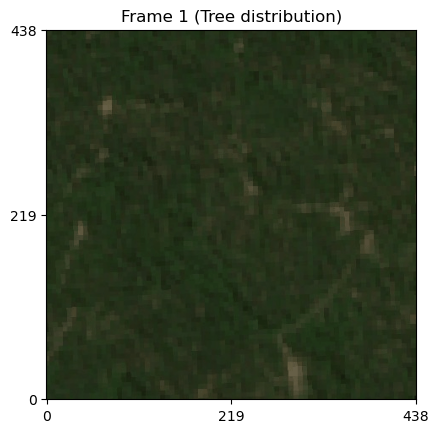

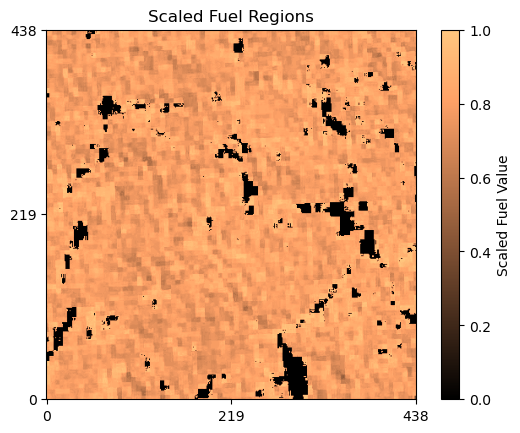

In [61]:
frame_index = 1  # frame 1 is before-burnt frame, whcih has the fuel (forest) information
thepixels = get_frame_pixels('timelapse-actual.gif', frame_index,f'Frame {frame_index} (Tree distribution)')

image_array = np.array(thepixels)

lower_gray = np.array([52, 0, 0])  # upper boundary for fuel

non_fuel = np.all((image_array >= lower_gray), axis=-1)

# Extract the G (green) channel from the image
green_channel = image_array[:, :, 1]

# Find the maximum value in the green channel for fuel regions
max_green_value = green_channel[~non_fuel].max()

# Initialize the output array with zeros
scaled_fuel = np.zeros_like(green_channel, dtype=np.float32)

# For fuel regions, do scaling, higher G value means more fuel
if max_green_value > 0:
    scaled_fuel[~non_fuel] = green_channel[~non_fuel] / max_green_value

# Visualize
plt.imshow(scaled_fuel, cmap='copper', origin='lower')
plt.title('Scaled Fuel Regions')
plt.xticks([0, spatial_resolution / 2, spatial_resolution], [0, int(spatial_resolution / 2), spatial_resolution])
plt.yticks([0, spatial_resolution / 2, spatial_resolution], [0, int(spatial_resolution / 2), spatial_resolution])
plt.colorbar(label='Scaled Fuel Value')
plt.savefig('Scaled Fuel Regions', dpi=300, bbox_inches='tight')
plt.show()


# Get Topography

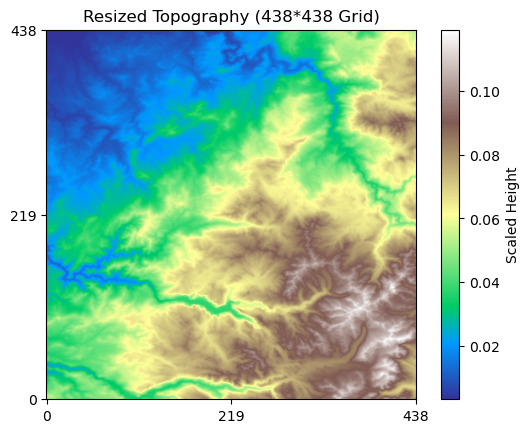

In [62]:
def normalize_array(array):
    """
    Normalize a 2D NumPy array such that:
    - Negative numbers are scaled to [-0.5, 0],
    - Positive numbers are scaled to [0, 0.5],
    - Zero remains 0.
    """
    normalized_array = array.astype(float)
    
    # Create masks for negative and positive values
    negative_mask = normalized_array < 0
    positive_mask = normalized_array > 0

    # Normalize negative values to [-1, 0]
    if np.any(negative_mask):
        neg_min = normalized_array[negative_mask].min()
        normalized_array[negative_mask] /= abs(neg_min)* 2

    # Normalize positive values to [0, 1]
    if np.any(positive_mask):
        pos_max = normalized_array[positive_mask].max()
        normalized_array[positive_mask] /= pos_max *2

    return normalized_array

def gradient_operator(map_x,dx):
    # Compute the gradient using finite differences
    grad_x = np.zeros_like(map_x)
    grad_y = np.zeros_like(map_x)

    grad_x[:, 1:-1] = (map_x[:, 2:] - map_x[:, :-2]) / (2.0 * dx)        
    grad_y[1:-1, :] = (map_x[2:, :] - map_x[:-2, :]) / (2.0 * dx)


    return grad_x, grad_y


loaded_topography = np.load('elevation_data.npy')

# Transform the Topography data to a 489x537 grid and leave only [20:458,20:458]
resized_loaded_topography = resize(loaded_topography, (489, 537), mode='reflect')
resized_loaded_topography = resized_loaded_topography[20:458,20:458]

# Visualize the Resized Topography
plt.imshow(np.flipud(resized_loaded_topography), cmap='terrain') # np.flipud is because the simulation has y axis flipped
plt.title('Resized Topography (438*438 Grid)')
plt.colorbar(label='Scaled Height')
plt.xticks([0,spatial_resolution / 2,spatial_resolution],[0,int(spatial_resolution / 2),spatial_resolution])
plt.yticks([0,spatial_resolution / 2,spatial_resolution],[spatial_resolution,int(spatial_resolution / 2),0])
plt.savefig('Scaled Topography', dpi=300, bbox_inches='tight')
plt.show()

# Get Gradient of Topography
topography = gradient_operator(resized_loaded_topography,90/128)

# Normalize the Gradient to 0.5 and -0.5
Normalized_topography = []
Normalized_topography.append(normalize_array(topography[0]))
Normalized_topography.append(normalize_array(topography[1]))
Normalized_topography = np.array(Normalized_topography)

# Run Simulation

In [77]:
# Run the simulation
model = ForestFirePDE(k, epsilon, alpha, u_pc, q, spatial_length,spatial_resolution, temporal_length,delta_t,initial_fire,scaled_fuel,Normalized_topography)
fuel_list = model.run()


# Plot Simulation

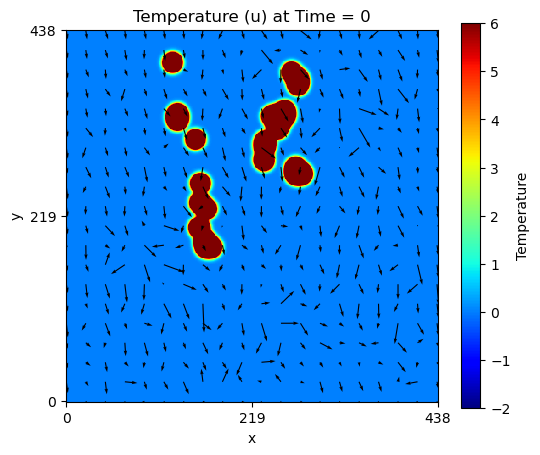

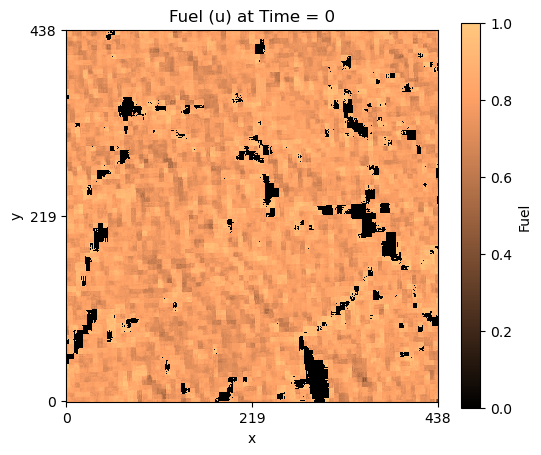

In [96]:
model.plot_t_and_f(0)

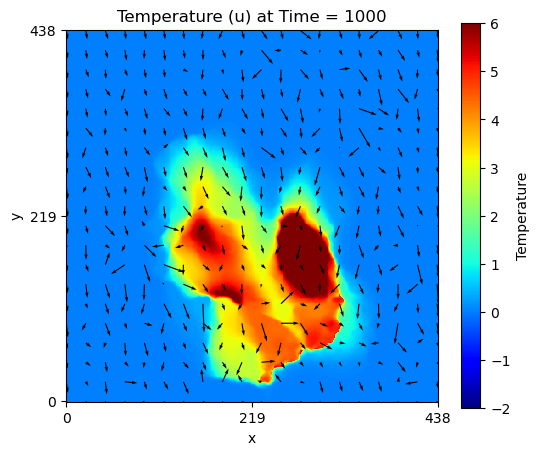

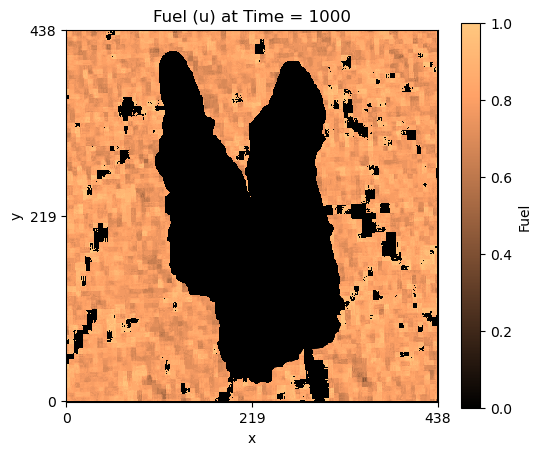

In [94]:
model.plot_t_and_f(1000)

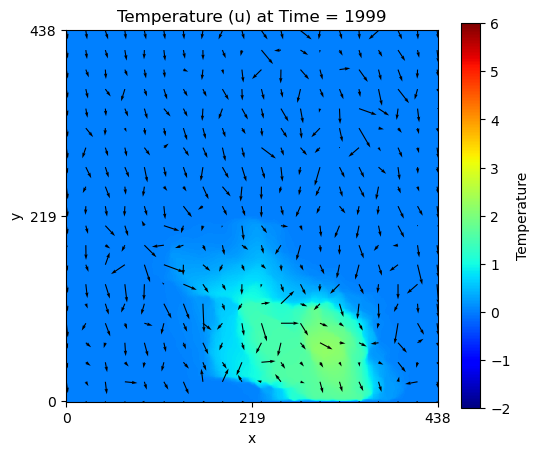

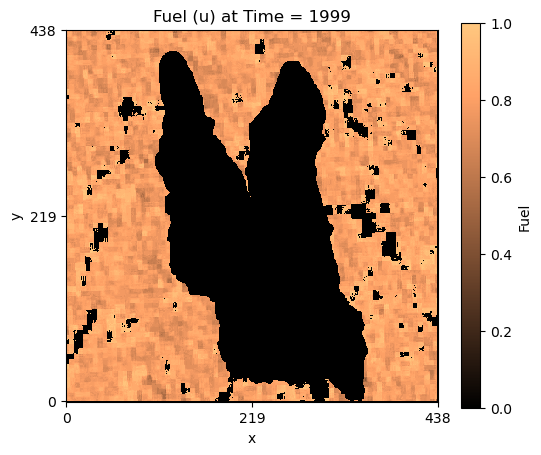

In [97]:
model.plot_t_and_f(1999)